In [1]:
from DP.utils import *
from DP.pga_mutliple_restarts import PGAETMultipleRestarts
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")
from matplotlib.patches import FancyArrowPatch

In [2]:
def cumulative(x, theta):
    return np.arctan(x - theta)/np.pi + 0.5

def quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def pmf_derivative(x, theta):
    return 2*(x - theta)/(np.pi * (1 + (x - theta)**2)**2)

In [3]:
from scipy.integrate import quad

k = 10
theta = 0
bin_endpoints = [quantile(i/k, theta) for i in range(k+1)]

p_theta = np.array([cumulative(bin_endpoints[i+1], theta) - cumulative(bin_endpoints[i], theta) for i in range(k)])
p_theta_dot = np.array(
    [
        quad(lambda x: pmf_derivative(x, theta), bin_endpoints[i], bin_endpoints[i+1])[0] for i in range(k)
    ]
)
epsilon = 1

def fisher_information(Q, p_theta, p_theta_dot):
    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    return np.sum(numerator/denominator)

In [10]:
from typing import Tuple

import cvxpy as cp
import numpy as np

from DP.utils import fisher_gradient, fisher_information_privatized, is_epsilon_private


def initialize_projection_solver(
    n_trials: int, epsilon: float
) -> Tuple[cp.Problem, cp.Variable, cp.Parameter]:
    Q_var = cp.Variable((n_trials, n_trials))
    Q_param = cp.Parameter((n_trials, n_trials))

    objective = cp.Minimize(cp.sum_squares(Q_var - Q_param))

    constraints = []
    constraints += [Q_var >= 0]

    for j in range(n_trials):
        constraints += [cp.sum(Q_var[:, j]) == 1]

    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_trials):
        Q_i = Q_var[i, :]
        constraints += [
            Q_i[j] - exp_neg_eps * Q_i[j_prime] >= 0
            for j in range(n_trials)
            for j_prime in range(n_trials)
            if j < j_prime
        ]
        constraints += [
            exp_eps * Q_i[j_prime] - Q_i[j] >= 0
            for j in range(n_trials)
            for j_prime in range(n_trials)
            if j < j_prime
        ]

    prob = cp.Problem(objective, constraints)

    return prob, Q_var, Q_param

def project_onto_feasible_set(prob: cp.Problem, Q_var: cp.Variable, Q_param: cp.Parameter, q_to_project: np.ndarray):
    Q_var.value = q_to_project
    Q_param.value = q_to_project
    prob.solve(solver=cp.SCS)
    return Q_var.value

In [11]:
def linesearch(
    q_initial: np.ndarray,
    direction: np.ndarray,
    p_theta,
    p_theta_dot,
    theta: float,
    epsilon: float,
    alpha_min=1.0,
    alpha_max=5.0,
    num_steps=10,
):
    """
    Perform a constrained line search to find the optimal alpha that maximizes
    fisher_information_privatized while satisfying epsilon-privacy constraints.

    Parameters
    ----------
    q_initial : np.ndarray
        Initial Q matrix.
    direction : np.ndarray
        Direction for line search.
    n_trials : int
        Number of trials for the Q matrix.
    theta : float
        Parameter value(s) for Fisher information evaluation.
    epsilon : float
        Privacy parameter.
    alpha_max : float, optional
        Maximum value for alpha.
    num_steps : int, optional
        Number of alpha steps to evaluate in the line search.

    Returns
    -------
    np.ndarray
        The updated Q matrix corresponding to the optimal alpha.
    """
    # Generate candidate alpha values
    alphas = np.linspace(alpha_min, alpha_max, num_steps)
    best_fish = -np.inf
    best_q = None

    for alpha in alphas:
        # Compute candidate Q matrix
        q_candidate = q_initial + alpha * direction
        q_candidate = np.vstack([q_candidate[:-1,:], 1 - np.sum(q_candidate[:-1,:], axis=0)])

        # Check feasibility
        if is_epsilon_private(q_candidate, epsilon, tol=1e-3):
            # Compute Fisher information
            fish_value = fisher_information(q_candidate, p_theta, p_theta_dot)

            # Update best solution if the Fisher information is higher
            if fish_value > best_fish:
                best_fish = fish_value
                best_q = q_candidate

    # Return the best feasible Q matrix found
    if best_q is None:
        #print(q_initial)
        #print(direction)
        #print(epsilon)
        #raise ValueError("No feasible solution found during line search.")
        #print("No feasible solution found during line search, returning the original value.")
        return q_initial

    return best_q

In [16]:
max_iter = 1000
tol=1e-4

# Initialize Q with random perturbation around a uniform matrix.
Q_init = np.ones((k, k)) / (
    k
) + np.random.normal(size=(k, k), scale=0.5)

projection_problem, Q_var, Q_param = initialize_projection_solver(
    k, epsilon
)
# inital projection
Q_init = project_onto_feasible_set(projection_problem, Q_var, Q_param, Q_init)

q = Q_init
current_fish = fisher_information(q, p_theta, p_theta_dot)
history = [q.copy()]

# Track intermediate projections for line search logic
first_projection = None
second_projection = None

for i in range(max_iter):
    q_linesearch = None
    
    if first_projection is not None and second_projection is not None:
        # If we have two projections, use them to perform a line search step
        diff = second_projection - first_projection
        diff[-1, :] = 0
        q_linesearch = linesearch(q, diff, p_theta, p_theta_dot, theta, epsilon)
        # Reset projections after line search
        first_projection = None
        second_projection = None
        # if linesearch didn't find a feasible alpha value,
        # it simply returned the same value
        # we have to be careful not to trigger algorithm termination
        q_next = q_linesearch
    else:
        # Compute gradient of Fisher information
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)

        # Optional: gradient clipping or scaling if needed
        # For example:
        # grad_I = np.clip(grad_I, -1e5, 1e5)
        grad_I = grad_I / np.max([1, np.linalg.norm(grad_I, ord="fro") / 0.1])
        grad_I[-1, :] = 0

        # Perform the gradient ascent step
        q_next = q + grad_I #/ np.sqrt(20 * (i + 1))
        # fix the last row (column stochasticity)
        q_next = np.vstack([q_next[:-1,:], 1 - np.sum(q_next[:-1,:], axis=0)])

        # Check feasibility; if not private, project onto feasible region
        if not is_epsilon_private(q_next, epsilon, tol=1e-10):
            history.append(q_next.copy())
            q_projected = project_onto_feasible_set(projection_problem, Q_var, Q_param, q_next)

            history.append(q_projected.copy())
            if first_projection is not None:
                second_projection = q_projected
            else:
                first_projection = q_projected

            q_next = q_projected

    # Evaluate Fisher information at the candidate Q
    next_fish = fisher_information(q_next, p_theta, p_theta_dot)

    # Check for convergence
    # 1. If Q hasn't moved significantly
    # 2. If Fisher information improvement is below threshold
    # 3. q and q_linesearch can't be equal
    if (
        np.allclose(q, q_next, rtol=tol, atol=tol)
        and abs(current_fish - next_fish) < 1e-3
        and not np.array_equal(q, q_linesearch)
    ):
        status = f"Converged after {i+1} iterations."
        q = q_next
        history.append(q.copy())
        break

    # Update for next iteration
    q = q_next
    current_fish = next_fish
    history.append(q.copy())
    status = "Max iterations reached without convergence"


In [17]:
all_history = np.array(history)
all_history[-1]

array([[3.17741412e-02, 3.17740113e-02, 3.17740091e-02, 3.17740114e-02,
        3.17740167e-02, 8.63706425e-02, 8.63701068e-02, 8.63701441e-02,
        8.63701200e-02, 3.17740190e-02],
       [5.06931600e-02, 5.06930303e-02, 5.06930281e-02, 5.06930304e-02,
        5.06930357e-02, 1.37797868e-01, 1.37797333e-01, 1.37797370e-01,
        1.37797346e-01, 5.06930380e-02],
       [7.67216318e-02, 7.67215022e-02, 7.67215001e-02, 7.67215023e-02,
        7.67215077e-02, 2.08550591e-01, 2.08550055e-01, 2.08550092e-01,
        2.08550068e-01, 7.67215100e-02],
       [3.22670074e-02, 3.22668774e-02, 3.22668753e-02, 3.22668775e-02,
        3.22668829e-02, 8.77103917e-02, 8.77098560e-02, 8.77098932e-02,
        8.77098691e-02, 3.22668851e-02],
       [2.60943814e-02, 2.60942514e-02, 2.60942493e-02, 2.60942515e-02,
        2.60942568e-02, 7.09314544e-02, 7.09309187e-02, 7.09309560e-02,
        7.09309319e-02, 2.60942591e-02],
       [9.67616849e-03, 9.67603837e-03, 9.67603624e-03, 9.67603847e-03,
   

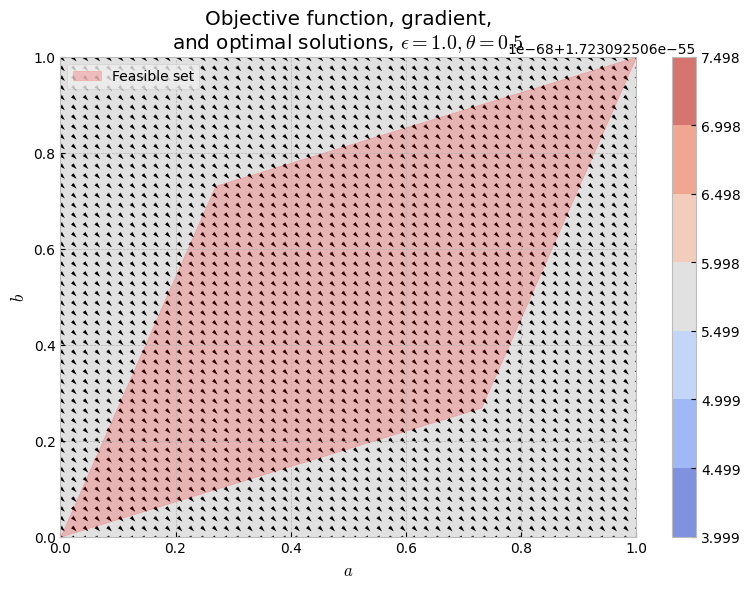

In [8]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q)

        fishers.append(fisher_information(q, p_theta, p_theta_dot))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

# Feasible area plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color="white", arrowstyle='->', mutation_scale=15, linewidth=3)
    ax.add_patch(arrow)

plt.legend()
plt.title("Objective function, gradient,\n" + fr"and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import cvxpy as cp
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("bmh")

# Utility functions for the Cauchy distribution
def cumulative(x, theta):
    return np.arctan(x - theta) / np.pi + 0.5

def quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def pmf_derivative(x, theta):
    return 2 * (x - theta) / (np.pi * (1 + (x - theta)**2)**2)

def fisher_information(Q, p_theta, p_theta_dot):
    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    # Safeguard against division by very small values
    denominator[denominator < 1e-12] = 1e-12
    return np.sum(numerator / denominator)

# Initialize bins and probabilities
k = 2  # Number of bins
theta = 0  # Location parameter
epsilon = 1  # Privacy parameter

bin_endpoints = [quantile(i / k, theta) for i in range(k + 1)]

p_theta = np.array([
    cumulative(bin_endpoints[i + 1], theta) - cumulative(bin_endpoints[i], theta)
    for i in range(k)
])

p_theta_dot = np.array([
    quad(lambda x: pmf_derivative(x, theta), bin_endpoints[i], bin_endpoints[i + 1])[0]
    for i in range(k)
])

# Debugging output
print("Initial p_theta (binned probabilities):", p_theta)
print("Initial p_theta_dot (derivative of binned probabilities):", p_theta_dot)

# Privacy constraint projection setup
def initialize_projection_solver(n_trials, epsilon):
    Q_var = cp.Variable((n_trials, n_trials))
    Q_param = cp.Parameter((n_trials, n_trials))

    objective = cp.Minimize(cp.sum_squares(Q_var - Q_param))

    constraints = [Q_var >= 0]
    for j in range(n_trials):
        constraints.append(cp.sum(Q_var[:, j]) == 1)

    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_trials):
        Q_i = Q_var[i, :]
        for j in range(n_trials):
            for j_prime in range(n_trials):
                if j < j_prime:
                    constraints.append(Q_i[j] - exp_neg_eps * Q_i[j_prime] >= 0)
                    constraints.append(exp_eps * Q_i[j_prime] - Q_i[j] >= 0)

    prob = cp.Problem(objective, constraints)
    return prob, Q_var, Q_param

def project_onto_feasible_set(prob, Q_var, Q_param, q_to_project):
    Q_param.value = q_to_project
    prob.solve(solver=cp.SCS)
    if prob.status != 'optimal':
        print("Projection failed with status:", prob.status)
    return Q_var.value

# Line search utility
def linesearch(q_initial, direction, p_theta, p_theta_dot, epsilon, alpha_min=1.0, alpha_max=5.0, num_steps=10):
    alphas = np.linspace(alpha_min, alpha_max, num_steps)
    best_fish = -np.inf
    best_q = None

    for alpha in alphas:
        q_candidate = q_initial + alpha * direction
        q_candidate = np.vstack([q_candidate[:-1, :], 1 - np.sum(q_candidate[:-1, :], axis=0)])

        if is_epsilon_private(q_candidate, epsilon):
            fish_value = fisher_information(q_candidate, p_theta, p_theta_dot)
            if fish_value > best_fish:
                best_fish = fish_value
                best_q = q_candidate

    if best_q is None:
        print("Line search failed to find a feasible solution.")
        return q_initial

    return best_q

# Initialize Q
Q_init = np.ones((k, k)) / k + np.random.normal(size=(k, k), scale=0.5)
projection_problem, Q_var, Q_param = initialize_projection_solver(k, epsilon)
Q_init = project_onto_feasible_set(projection_problem, Q_var, Q_param, Q_init)

# Debugging output
print("Initial Q after projection:", Q_init)

# Optimization loop
max_iter = 1000
tol = 1e-4
q = Q_init
current_fish = fisher_information(q, p_theta, p_theta_dot)
history = [q.copy()]

for i in range(max_iter):
    grad_I = fisher_gradient(p_theta, p_theta_dot, q)
    grad_I = grad_I / max(1, np.linalg.norm(grad_I, ord="fro") / 0.1)
    grad_I[-1, :] = 0

    q_next = q + grad_I
    q_next = np.vstack([q_next[:-1, :], 1 - np.sum(q_next[:-1, :], axis=0)])

    if not is_epsilon_private(q_next, epsilon):
        q_next = project_onto_feasible_set(projection_problem, Q_var, Q_param, q_next)

    next_fish = fisher_information(q_next, p_theta, p_theta_dot)

    if np.allclose(q, q_next, rtol=tol, atol=tol) and abs(current_fish - next_fish) < tol:
        print(f"Converged after {i + 1} iterations.")
        break

    q = q_next
    current_fish = next_fish
    history.append(q.copy())

print("Final Fisher Information:", current_fish)

Initial p_theta (binned probabilities): [0.5 0.5]
Initial p_theta_dot (derivative of binned probabilities): [-5.53079436e-27  5.53079436e-27]
Initial Q after projection: [[0.22224131 0.59567664]
 [0.77775865 0.40432338]]
Converged after 1 iterations.
Final Fisher Information: 1.7648524819689675e-53


Running optimization for k=2...
  Restart 1/5
Converged after 1 iterations for k=2.
  Restart 2/5
Converged after 1 iterations for k=2.
  Restart 3/5
Converged after 1 iterations for k=2.
  Restart 4/5
Converged after 1 iterations for k=2.
  Restart 5/5
Converged after 1 iterations for k=2.
Best Fisher Information for k=2: 3.961055222755298e-53
Running optimization for k=3...
  Restart 1/5
Converged after 1 iterations for k=3.
  Restart 2/5
Converged after 1 iterations for k=3.
  Restart 3/5
Converged after 1 iterations for k=3.
  Restart 4/5
Converged after 1 iterations for k=3.
  Restart 5/5
Converged after 1 iterations for k=3.
Best Fisher Information for k=3: 1.372551402311893e-32
Running optimization for k=4...
  Restart 1/5
Converged after 40 iterations for k=4.
  Restart 2/5
Converged after 45 iterations for k=4.
  Restart 3/5
Converged after 41 iterations for k=4.
  Restart 4/5
Converged after 37 iterations for k=4.
  Restart 5/5
Converged after 25 iterations for k=4.
Best Fish

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Projection failed with status: optimal_inaccurate
  Restart 4/5
  Restart 5/5
Best Fisher Information for k=15: 0.3893452028095903
Running optimization for k=16...
  Restart 1/5
  Restart 2/5
  Restart 3/5
  Restart 4/5
  Restart 5/5
Best Fisher Information for k=16: 0.37555617955684817
Running optimization for k=17...
  Restart 1/5
  Restart 2/5
  Restart 3/5
  Restart 4/5
  Restart 5/5
Best Fisher Information for k=17: 0.3836676508162825
Running optimization for k=18...
  Restart 1/5
  Restart 2/5
  Restart 3/5
  Restart 4/5
  Restart 5/5
Best Fisher Information for k=18: 0.3847188494686232
Running optimization for k=19...
  Restart 1/5
  Restart 2/5
  Restart 3/5
  Restart 4/5
  Restart 5/5
Best Fisher Information for k=19: 0.38235778733104103
Running optimization for k=20...
  Restart 1/5
Projection failed with status: optimal_inaccurate
  Restart 2/5
  Restart 3/5
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
  Restart 4/5
Proj

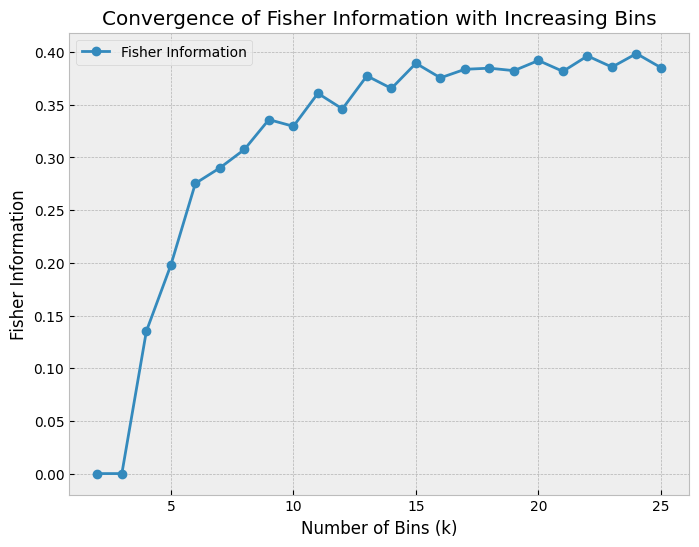

In [5]:
import numpy as np
import cvxpy as cp
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("bmh")

# Utility functions for the Cauchy distribution
def cumulative(x, theta):
    return np.arctan(x - theta) / np.pi + 0.5

def quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def pmf_derivative(x, theta):
    return 2 * (x - theta) / (np.pi * (1 + (x - theta)**2)**2)

def fisher_information(Q, p_theta, p_theta_dot):
    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    # Safeguard against division by very small values
    denominator[denominator < 1e-12] = 1e-12
    return np.sum(numerator / denominator)

# Initialize bins and probabilities
def initialize_bins_and_probabilities(k, theta):
    bin_endpoints = [quantile(i / k, theta) for i in range(k + 1)]
    p_theta = np.array([
        cumulative(bin_endpoints[i + 1], theta) - cumulative(bin_endpoints[i], theta)
        for i in range(k)
    ])
    p_theta_dot = np.array([
        quad(lambda x: pmf_derivative(x, theta), bin_endpoints[i], bin_endpoints[i + 1])[0]
        for i in range(k)
    ])
    return p_theta, p_theta_dot

# Privacy constraint projection setup
def initialize_projection_solver(n_trials, epsilon):
    Q_var = cp.Variable((n_trials, n_trials))
    Q_param = cp.Parameter((n_trials, n_trials))

    objective = cp.Minimize(cp.sum_squares(Q_var - Q_param))

    constraints = [Q_var >= 0]
    for j in range(n_trials):
        constraints.append(cp.sum(Q_var[:, j]) == 1)

    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_trials):
        Q_i = Q_var[i, :]
        for j in range(n_trials):
            for j_prime in range(n_trials):
                if j < j_prime:
                    constraints.append(Q_i[j] - exp_neg_eps * Q_i[j_prime] >= 0)
                    constraints.append(exp_eps * Q_i[j_prime] - Q_i[j] >= 0)

    prob = cp.Problem(objective, constraints)
    return prob, Q_var, Q_param

def project_onto_feasible_set(prob, Q_var, Q_param, q_to_project):
    Q_param.value = q_to_project
    prob.solve(solver=cp.SCS)
    if prob.status != 'optimal':
        print("Projection failed with status:", prob.status)
    return Q_var.value

# Line search utility
def linesearch(q_initial, direction, p_theta, p_theta_dot, epsilon, alpha_min=1.0, alpha_max=5.0, num_steps=10):
    alphas = np.linspace(alpha_min, alpha_max, num_steps)
    best_fish = -np.inf
    best_q = None

    for alpha in alphas:
        q_candidate = q_initial + alpha * direction
        q_candidate = np.vstack([q_candidate[:-1, :], 1 - np.sum(q_candidate[:-1, :], axis=0)])

        if is_epsilon_private(q_candidate, epsilon):
            fish_value = fisher_information(q_candidate, p_theta, p_theta_dot)
            if fish_value > best_fish:
                best_fish = fish_value
                best_q = q_candidate

    if best_q is None:
        print("Line search failed to find a feasible solution.")
        return q_initial

    return best_q

# Optimization loop
def optimize_fisher_information(k, theta, epsilon, max_iter=1000, tol=1e-4):
    p_theta, p_theta_dot = initialize_bins_and_probabilities(k, theta)

    Q_init = np.ones((k, k)) / k + np.random.normal(size=(k, k), scale=0.5)
    projection_problem, Q_var, Q_param = initialize_projection_solver(k, epsilon)
    Q_init = project_onto_feasible_set(projection_problem, Q_var, Q_param, Q_init)

    q = Q_init
    current_fish = fisher_information(q, p_theta, p_theta_dot)
    history = [q.copy()]

    for i in range(max_iter):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        grad_I = grad_I / max(1, np.linalg.norm(grad_I, ord="fro") / 0.1)
        grad_I[-1, :] = 0

        q_next = q + grad_I
        q_next = np.vstack([q_next[:-1, :], 1 - np.sum(q_next[:-1, :], axis=0)])

        if not is_epsilon_private(q_next, epsilon):
            q_next = project_onto_feasible_set(projection_problem, Q_var, Q_param, q_next)

        next_fish = fisher_information(q_next, p_theta, p_theta_dot)

        if np.allclose(q, q_next, rtol=tol, atol=tol) and abs(current_fish - next_fish) < tol:
            print(f"Converged after {i + 1} iterations for k={k}.")
            break

        q = q_next
        current_fish = next_fish
        history.append(q.copy())

    return current_fish

# Function to observe Fisher information convergence
def observe_fisher_information_convergence(theta=0, epsilon=1, max_bins=50, restarts=5):
    fisher_values = []
    bin_counts = range(2, max_bins + 1)

    for k in bin_counts:
        print(f"Running optimization for k={k}...")
        best_fish = -np.inf

        for restart in range(restarts):
            print(f"  Restart {restart + 1}/{restarts}")
            fisher_value = optimize_fisher_information(k, theta, epsilon, max_iter=100)
            if fisher_value > best_fish:
                best_fish = fisher_value

        fisher_values.append(best_fish)
        print(f"Best Fisher Information for k={k}: {best_fish}")

    # Plot convergence
    plt.figure(figsize=(8, 6))
    plt.plot(bin_counts, fisher_values, marker='o', label='Fisher Information')
    #plt.axhline(y=0.5, color='r', linestyle='--', label='Expected Limit (1/2)')
    plt.xlabel('Number of Bins (k)')
    plt.ylabel('Fisher Information')
    plt.title('Convergence of Fisher Information with Increasing Bins')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
observe_fisher_information_convergence(theta=0, epsilon=10, max_bins=25, restarts=5)

Running optimization for k=2...
  Restart 1/5
Converged after 1 iterations for k=2.
  Restart 2/5
Converged after 1 iterations for k=2.
  Restart 3/5
Converged after 1 iterations for k=2.
  Restart 4/5
Converged after 1 iterations for k=2.
  Restart 5/5
Converged after 1 iterations for k=2.
Best Fisher Information for k=2: 2.0298643570164746e-53
Running optimization for k=3...
  Restart 1/5
Converged after 1 iterations for k=3.
  Restart 2/5
Converged after 1 iterations for k=3.
  Restart 3/5
Converged after 1 iterations for k=3.
  Restart 4/5
Converged after 1 iterations for k=3.
  Restart 5/5
Converged after 1 iterations for k=3.
Best Fisher Information for k=3: 5.937357568484327e-33
Running optimization for k=4...
  Restart 1/5
Converged after 59 iterations for k=4.
  Restart 2/5
Converged after 44 iterations for k=4.
  Restart 3/5
Converged after 50 iterations for k=4.
  Restart 4/5
Converged after 22 iterations for k=4.
  Restart 5/5
Converged after 15 iterations for k=4.
Best Fis

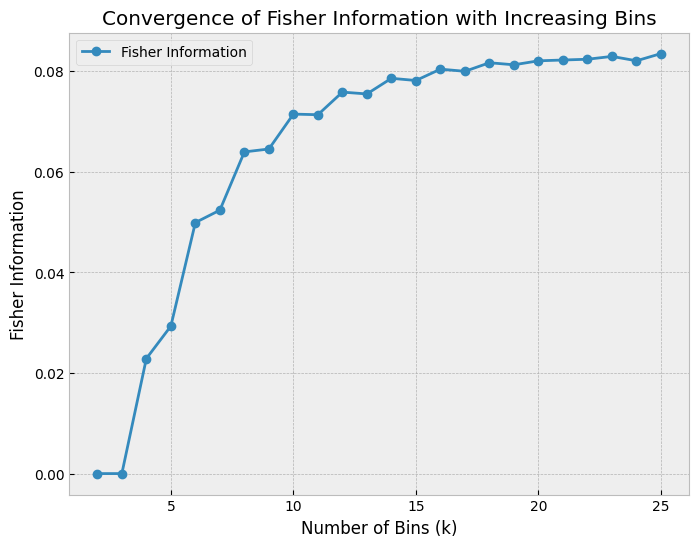

In [6]:
observe_fisher_information_convergence(theta=0, epsilon=1, max_bins=25, restarts=5)

Running optimization for k=2...
  Restart 1/1
Converged after 12 iterations for k=2.
Best Fisher Information for k=2: 0.6366317971148
Running optimization for k=3...
  Restart 1/1
Converged after 86 iterations for k=3.
Best Fisher Information for k=3: 0.5947910237340459
Running optimization for k=4...
  Restart 1/1
Converged after 150 iterations for k=4.
Best Fisher Information for k=4: 0.5384425254029932
Running optimization for k=5...
  Restart 1/1
Converged after 30 iterations for k=5.
Best Fisher Information for k=5: 0.48973556630163984
Running optimization for k=6...
  Restart 1/1
Converged after 327 iterations for k=6.
Best Fisher Information for k=6: 0.6503433212287091
Running optimization for k=7...
  Restart 1/1
Converged after 374 iterations for k=7.
Best Fisher Information for k=7: 0.6093828084157852
Running optimization for k=8...
  Restart 1/1
Converged after 697 iterations for k=8.
Best Fisher Information for k=8: 0.573618296243815
Running optimization for k=9...
  Restar

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate
Projection failed with status: optimal_inaccurate


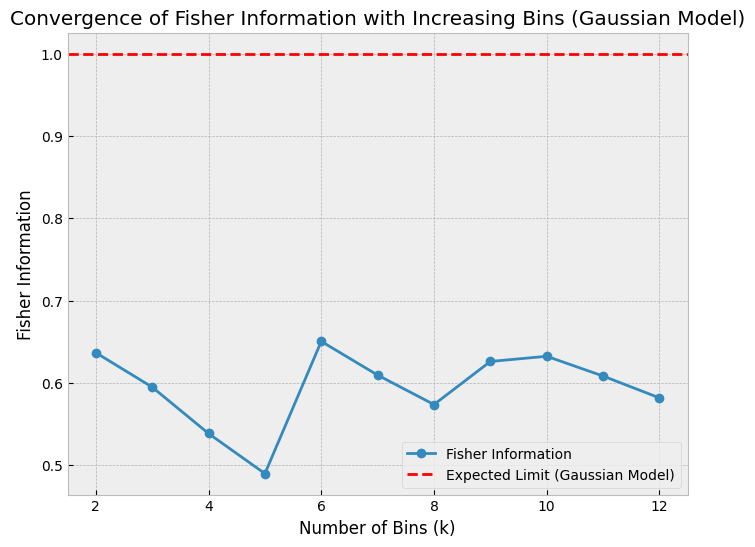

In [37]:
import numpy as np
import cvxpy as cp
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("bmh")

# Utility functions for the Gaussian distribution
def gaussian_cumulative(x, theta, sigma=1):
    from scipy.stats import norm
    return norm.cdf(x, loc=theta, scale=sigma)

def gaussian_quantile(p, theta, sigma=1):
    from scipy.stats import norm
    return norm.ppf(p, loc=theta, scale=sigma)

def gaussian_pmf_derivative(x, theta, sigma=1):
    return -(x - theta) / (sigma**2) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - theta) / sigma)**2)

def fisher_information(Q, p_theta, p_theta_dot):
    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    # Safeguard against division by very small values
    denominator[denominator < 1e-12] = 1e-12
    return np.sum(numerator / denominator)

# Initialize bins and probabilities for Gaussian model
def initialize_gaussian_bins_and_probabilities(k, theta, sigma=1):
    bin_endpoints = [gaussian_quantile(i / k, theta, sigma) for i in range(k + 1)]
    p_theta = np.array([
        gaussian_cumulative(bin_endpoints[i + 1], theta, sigma) - gaussian_cumulative(bin_endpoints[i], theta, sigma)
        for i in range(k)
    ])
    p_theta_dot = np.array([
        quad(lambda x: gaussian_pmf_derivative(x, theta, sigma), bin_endpoints[i], bin_endpoints[i + 1])[0]
        for i in range(k)
    ])
    return p_theta, p_theta_dot

# Privacy constraint projection setup
def initialize_projection_solver(n_trials, epsilon):
    Q_var = cp.Variable((n_trials, n_trials))
    Q_param = cp.Parameter((n_trials, n_trials))

    objective = cp.Minimize(cp.sum_squares(Q_var - Q_param))

    constraints = [Q_var >= 0]
    for j in range(n_trials):
        constraints.append(cp.sum(Q_var[:, j]) == 1)

    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_trials):
        Q_i = Q_var[i, :]
        for j in range(n_trials):
            for j_prime in range(n_trials):
                if j < j_prime:
                    constraints.append(Q_i[j] - exp_neg_eps * Q_i[j_prime] >= 0)
                    constraints.append(exp_eps * Q_i[j_prime] - Q_i[j] >= 0)

    prob = cp.Problem(objective, constraints)
    return prob, Q_var, Q_param

def project_onto_feasible_set(prob, Q_var, Q_param, q_to_project):
    Q_param.value = q_to_project
    prob.solve(solver=cp.SCS)
    if prob.status != 'optimal':
        print("Projection failed with status:", prob.status)
    return Q_var.value

# Line search utility
def linesearch(q_initial, direction, p_theta, p_theta_dot, epsilon, alpha_min=1.0, alpha_max=5.0, num_steps=10):
    alphas = np.linspace(alpha_min, alpha_max, num_steps)
    best_fish = -np.inf
    best_q = None

    for alpha in alphas:
        q_candidate = q_initial + alpha * direction
        q_candidate = np.vstack([q_candidate[:-1, :], 1 - np.sum(q_candidate[:-1, :], axis=0)])

        if is_epsilon_private(q_candidate, epsilon):
            fish_value = fisher_information(q_candidate, p_theta, p_theta_dot)
            if fish_value > best_fish:
                best_fish = fish_value
                best_q = q_candidate

    if best_q is None:
        print("Line search failed to find a feasible solution.")
        return q_initial

    return best_q

# Optimization loop
def optimize_fisher_information(k, theta, epsilon, sigma=1, max_iter=1000, tol=1e-4):
    p_theta, p_theta_dot = initialize_gaussian_bins_and_probabilities(k, theta, sigma)

    Q_init = np.ones((k, k)) / k + np.random.normal(size=(k, k), scale=0.5)
    projection_problem, Q_var, Q_param = initialize_projection_solver(k, epsilon)
    Q_init = project_onto_feasible_set(projection_problem, Q_var, Q_param, Q_init)

    q = Q_init
    current_fish = fisher_information(q, p_theta, p_theta_dot)
    history = [q.copy()]

    for i in range(max_iter):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        grad_I = grad_I / max(1, np.linalg.norm(grad_I, ord="fro") / 0.1)
        grad_I[-1, :] = 0

        q_next = q + grad_I
        q_next = np.vstack([q_next[:-1, :], 1 - np.sum(q_next[:-1, :], axis=0)])

        if not is_epsilon_private(q_next, epsilon):
            q_next = project_onto_feasible_set(projection_problem, Q_var, Q_param, q_next)

        next_fish = fisher_information(q_next, p_theta, p_theta_dot)

        if np.allclose(q, q_next, rtol=tol, atol=tol) and abs(current_fish - next_fish) < tol:
            print(f"Converged after {i + 1} iterations for k={k}.")
            break

        q = q_next
        current_fish = next_fish
        history.append(q.copy())

    return current_fish

# Function to observe Fisher information convergence
def observe_fisher_information_convergence_gaussian(theta=0, epsilon=1, sigma=1, max_bins=50, restarts=5):
    fisher_values = []
    bin_counts = range(2, max_bins + 1)

    for k in bin_counts:
        print(f"Running optimization for k={k}...")
        best_fish = -np.inf

        for restart in range(restarts):
            print(f"  Restart {restart + 1}/{restarts}")
            fisher_value = optimize_fisher_information(k, theta, epsilon, sigma)
            if fisher_value > best_fish:
                best_fish = fisher_value

        fisher_values.append(best_fish)
        print(f"Best Fisher Information for k={k}: {best_fish}")

    # Plot convergence
    plt.figure(figsize=(8, 6))
    plt.plot(bin_counts, fisher_values, marker='o', label='Fisher Information')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Expected Limit (Gaussian Model)')
    plt.xlabel('Number of Bins (k)')
    plt.ylabel('Fisher Information')
    plt.title('Convergence of Fisher Information with Increasing Bins (Gaussian Model)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
observe_fisher_information_convergence_gaussian(theta=0, epsilon=10, sigma=1, max_bins=12, restarts=1)